In [40]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [41]:
#read the user engagement data
df = pd.read_csv(r'E:/Data Science/takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [42]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    df['user_id'].nunique(), len(df)
))

There were 8823 users and 207917 total logins


In [43]:
# convert time_stamp into datetime format
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [44]:
# define a function to see if a user logged on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [45]:
# run the function on all users
adopted = df.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [46]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [47]:
# read the user data
# some columns such as name, email address are not useful here
# let's not read them
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv(r'E:/Data Science/takehome_users.csv', usecols=cols)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [48]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [49]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [50]:
# remove those two features
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

From the creation time and last session time, we can engineer two features that can be useful.
It is possible that the history of using the software might be a factor of becoming "adopted users". In other words, users who have used the software for a long time might be more likely to be "adopted users" than those who had just signed up.
It is likely that user adoption rate vary through time, so it is useful to take a look at account age (based on creation time) as well.

# create a feature of user history
# convert both time features into datetime

In [52]:
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [53]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [54]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


There were 8823 users who had "user history" out of 12000. It was not clear from the challenge description whether data for other users were missing, or don't exist at all. However, given there are users who has history of 0 days, I think the engagement data for the other users were simply missing. Therefore, I will remove these users from the analysis.

In [55]:
# merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

# EDA

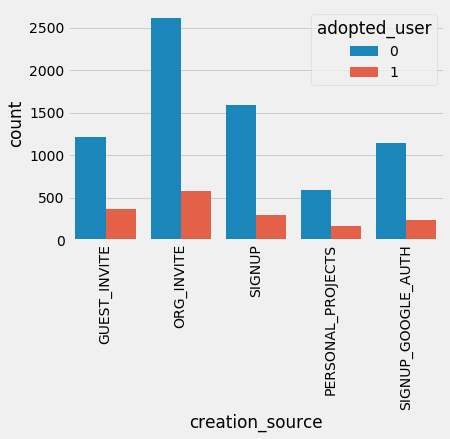

In [56]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [57]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148219, p = 0.4820695142048773


In [58]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [59]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940353, p = 0.6870022995069649


There was really no difference between users who signed up or not for mailing list and marketing drip.

# Predictive Modeling

In [60]:
# make dummy variable for creation source
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [61]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.962521322728487


In [62]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [63]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.896213
account_age                   0.088842
opted_in_to_mailing_list      0.003002
SIGNUP                        0.002919
enabled_for_marketing_drip    0.002682
ORG_INVITE                    0.002350
PERSONAL_PROJECTS             0.002069
SIGNUP_GOOGLE_AUTH            0.001923
dtype: float64


# CONCLUSION:

It is clear that the user history is the most important feature. 
The next important feature is how user signed up